# Dask Distributed Computing

L'obiettivo di questo Notebook è mostrare come Dask supera le limitazioni di Pandas eseguendo le stesse operazioni del Notebook 1 ma utilizzando il dataset completo (100M records)

**Dataset**: 
- Source: `data/raw/` (FULL dataset)
- Transactions: 100M records

# Setup & Enviroments

Nelle seguenti celle verranno importate tutte le librerie necessarie e definite alcune funzioni ausiliarie per misurare le performance di Dask.

In [1]:
# IMPORT

# Standard library imports
import pandas as pd
import numpy as np
import time
import gc
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Dask imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')


print("Libraries imported successfully!")
print(f"Dask version: {dask.__version__}")

Libraries imported successfully!
Dask version: 2025.2.0


In [2]:
# HELPER FUNCTION

def measure_dask_performance(func, *args, **kwargs):
    """Measure execution time for Dask operations"""
    start_time = time.time()
    result = func(*args, **kwargs)
    
    if hasattr(result, 'compute'):
        result = result.compute()
    
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def format_bytes(bytes_value):
    """Format bytes to human-readable string"""
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes_value < 1024.0:
            return f"{bytes_value:.2f} {unit}"
        bytes_value /= 1024.0
    return f"{bytes_value:.2f} PB"

print("Helper functions defined!")

Helper functions defined!


In [3]:
# PATHS CONFIGURATION

# Data paths
DATA_DIR = Path("../data/raw/")
RESULTS_DIR = Path("../docs/results")
GRAPH_DIR = Path("../docs/graphs")

TRANSACTIONS_FILE = DATA_DIR / "transactions"
CUSTOMERS_FILE = DATA_DIR / "customers.parquet"
PRODUCTS_FILE = DATA_DIR / "products.parquet"

# Verify files
print("Checking data files...")
for file_path in [TRANSACTIONS_FILE, CUSTOMERS_FILE, PRODUCTS_FILE]:
    if file_path.exists():
        size = file_path.stat().st_size
        print(f"  {file_path.name}: OK")
    else:
        print(f"  {file_path.name}: NOT FOUND")

Checking data files...
  transactions: OK
  customers.parquet: OK
  products.parquet: OK


# Fondamenta di Dask

**1. Lazy Evaluation**

Le operazioni vengono registrate ma non eseguite immediatamente. Questo permette a Dask di:
- Ottimizzare l'intera pipeline di calcolo
- Evitare calcoli intermedi inutili
- Parallelizzare in modo intelligente

Il metodo `.compute()` esegue effettivamente le operazioni portando in memoria il risultato.

**2. Partitioni**

Il dataset viene suddiviso in partizioni le quali vengono processate parallelamente. Ciò consente a Dask di analizzare dataset enormi anche con risorse limitate

**3. Task Graph**

Dask costruisce un **grafo delle dipendenze** (task graph) che rappresenta tutte le operazioni da eseguire e le loro relazioni eliminando operazioni ridondanti, ottimizzando l'ordine di esecuzione e massimizzando il parallelismo.

In [4]:
# DASK FUNDAMENTALS

print("="*70)
print("DASK FUNDAMENTALS")
print("="*70 + "\\n")

# Define dtypes for efficient loading
dtypes = {
    'customer_id': 'category',
    'product_id': 'category',
    'quantity': 'int32',
    'unit_price': 'float32',
    'total_amount': 'float32',
    'discount_pct': 'float32',
    'final_amount': 'float32',
    'shipping_cost': 'float32',
    'payment_method': 'category',
    'status': 'category'
}

print("Dtypes configured")


# Lazy loading demonstration
print("\n[1/3] Loading with Dask (LAZY!)\n")

start = time.time()

ddf = dd.read_parquet(
    TRANSACTIONS_FILE,
    dtype=dtypes,
    parse_dates=['transaction_date'],
)

load_time = time.time() - start

print(f"  Loaded in {load_time:.2f}s (instant - lazy!)")
print(f"\nDask DataFrame:")
print(f"  Type: {type(ddf)}")
print(f"  Partitions: {ddf.npartitions}")
print(f"  Columns: {len(ddf.columns)}")

# Demonstrate lazy evaluation
print("\n[2/3] Lazy Evaluation Demo\n")

# These don't execute!
filtered = ddf[ddf['final_amount'] > 1000]
aggregated = filtered.groupby('payment_method')['final_amount'].sum()

print("Created operations (no execution yet):")
print(f"  Filter: {type(filtered)}")
print(f"  GroupBy: {type(aggregated)}")

# Visualize task graph
print("\n[3/3] Task Graph\n")

try:
    aggregated.visualize(filename=str(GRAPH_DIR / '02_task_graph.png'))
    print("  Task graph saved: 02_task_graph.png")
except Exception as e:
    print(f"Note: {e}")

DASK FUNDAMENTALS
======================================================================\n
Dtypes configured

[1/3] Loading with Dask (LAZY!)

  Loaded in 0.09s (instant - lazy!)

Dask DataFrame:
  Type: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
  Partitions: 240
  Columns: 16

[2/3] Lazy Evaluation Demo

Created operations (no execution yet):
  Filter: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
  GroupBy: <class 'dask.dataframe.dask_expr._collection.Series'>

[3/3] Task Graph

  Task graph saved: 02_task_graph.png


## Operazioni Base con Dask

Nella seguente cella di codice eseguiremo le stesse operazioni del Notebook 1 ma con 100M records

- Filtro
- GroupBy + Aggregazione
- Date parsing
- Aggregazione complessa multi livello


In [5]:
# BASIC OPERATIONS

print("="*70)
print("BASIC OPERATIONS (100M RECORDS)")
print("="*70 + "\n")

dask_performance = {}

print("[1/4] Filter Operation")
print("  Task: final_amount > 1000\n")

start = time.time()
result_filter = ddf[ddf['final_amount'] > 1000].compute()
time_filter = time.time() - start

dask_performance['Filter'] = time_filter

print(f"    Filtered to {len(result_filter):,} records")
print(f"    Time: {time_filter:.2f}s\n")

del result_filter
gc.collect()
time.sleep(5)

print("\n[2/4] GroupBy Aggregation")

start = time.time()
result_groupby = ddf.groupby('payment_method', observed=True)['final_amount'].agg(['sum', 'mean', 'count']).compute()
time_groupby = time.time() - start

dask_performance['GroupBy'] = time_groupby

print(f"    Time: {time_groupby:.2f}s\n")
print(result_groupby)

del result_groupby
gc.collect()
time.sleep(5)

print("\n[3/4] Date Operations")

start = time.time()
ddf_month = ddf.assign(
    month_period=dd.to_datetime(
        ddf['year'].astype(str) + '-' + ddf['month'].astype(str).str.zfill(2) + '-01'
    ).dt.to_period('M')
)
result_date = ddf_month.groupby('month')['final_amount'].sum().compute()
time_date = time.time() - start

dask_performance['Date Parse'] = time_date

print(f"    Time: {time_date:.2f}s")
print(f"    Months: {len(result_date)}\n")

del result_date
gc.collect()
time.sleep(5)


print("\n[4/4] Complex Multi-Level Aggregation")

start = time.time()
result_complex = ddf_month.groupby(['month', 'payment_method'], observed=True)['final_amount'].agg(['sum', 'count']).compute()
time_complex = time.time() - start

dask_performance['Complex Agg'] = time_complex

print(f"    Time: {time_complex:.2f}s")
print(f"    Shape: {result_complex.shape}")
print("\nPreview:")
print(result_complex.head(5))

del result_complex
gc.collect()
time.sleep(5)

print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70 + "\n")

perf_dask = pd.DataFrame(list(dask_performance.items()), columns=['Operation', 'Time (s)'])
perf_dask = perf_dask.set_index('Operation')

print(perf_dask.round(2))
print(f"\nTotal: {perf_dask['Time (s)'].sum():.2f}s")

perf_dask.to_csv(RESULTS_DIR / '02_dask_performance.csv')
print("\nSaved: 02_dask_performance.csv")

del ddf
gc.collect()
time.sleep(5)

BASIC OPERATIONS (100M RECORDS)

[1/4] Filter Operation
  Task: final_amount > 1000

    Filtered to 8,233,328 records
    Time: 10.50s


[2/4] GroupBy Aggregation
    Time: 2.11s

                           sum   mean     count
payment_method                                 
cash_on_delivery 8229230144.91 411.31  20007224
bank_transfer    8233634654.19 411.69  19999812
paypal           8228051088.78 411.46  19997343
debit_card       8225151960.52 411.39  19993488
credit_card      8233812375.38 411.65  20002133

[3/4] Date Operations
    Time: 1.71s
    Months: 36


[4/4] Complex Multi-Level Aggregation
    Time: 3.16s
    Shape: (60, 2)

Preview:
                              sum    count
month payment_method                      
9     credit_card    677008702.91  1644751
10    bank_transfer  698704272.65  1698260
11    paypal         675893218.87  1643199
      credit_card    675497783.48  1643284
5     paypal         698066073.01  1699263

PERFORMANCE SUMMARY

             Time (s)

## Dask Schedulers

Dask offre tre tipologie principali di scheduler, ciascuno ottimizzato per scenari specifici.

**1. Threads Scheduler** (Default)
Si basa sull'utilizzo di thread Python. Questo scheduler risulta particolarmente efficace per attività legate all'I/O, come la lettura di file o le operazioni di rete. Tuttavia, presenta una limitazione intrinseca dovuta al GIL (Global Interpreter Lock) di Python. Nonostante questo vincolo, rappresenta la scelta migliore quando si lavora con sorgenti dati esterne.

**2. Processes Scheduler**
Utilizza processi Python separati anziché thread. Questo scheduler eccelle nelle attività che richiedono un uso intensivo della CPU, come i calcoli computazionalmente pesanti. Il suo principale vantaggio consiste nella capacità di aggirare il GIL, consentendo un vero parallelismo.

**3. Distributed Scheduler**
Rappresenta la soluzione di livello professionale. È progettato specificamente per ambienti di produzione e offre funzionalità avanzate di monitoraggio. Tra le sue caratteristiche principali spiccano una dashboard web per il controllo visuale, strumenti diagnostici avanzati e la possibilità di scalare su più macchine. Questo scheduler diventa la scelta ottimale quando sono necessarie funzionalità di monitoraggio, debugging approfondito o quando si deve effettuare un deployment in produzione.

PART 4: SCHEDULERS COMPARISON

[1/3] THREADS SCHEDULER

  Time: 2.07s
payment_method
bank_transfer      8233634654.19
cash_on_delivery   8229230144.91
debit_card         8225151960.52
paypal             8228051088.78
credit_card        8233812375.38
Name: final_amount, dtype: float64

[2/3] PROCESSES SCHEDULER

  Time: 3.12s
payment_method
bank_transfer      8233634654.19
cash_on_delivery   8229230144.91
debit_card         8225151960.52
paypal             8228051088.78
credit_card        8233812375.38
Name: final_amount, dtype: float64

[3/3] DISTRIBUTED SCHEDULER

Cluster started
  Workers: 6
  Dashboard: http://127.0.0.1:8787/status
  Time: 2.79s
payment_method
bank_transfer      8233634654.19
cash_on_delivery   8229230144.91
debit_card         8225151960.52
paypal             8228051088.78
credit_card        8233812375.38
Name: final_amount, dtype: float64

SCHEDULER COMPARISON

             Time (s)    Use Case
Threads          2.07   I/O bound
Processes        3.12   CPU bound
Dis

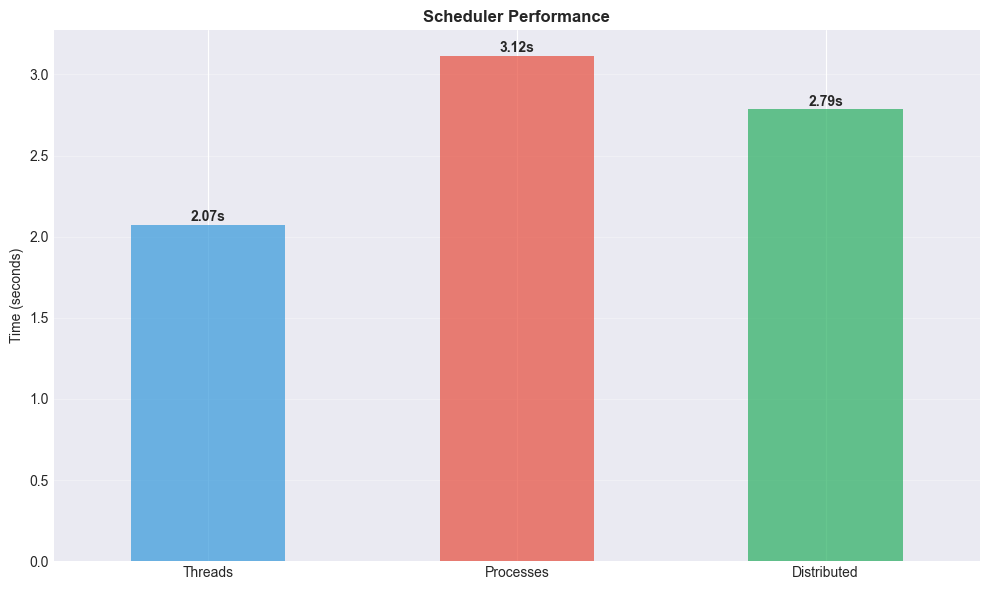


Saved: 02_scheduler_comparison.png

Closing Dask client...
Client closed


In [6]:
# SCHEDULERS COMPARISON

print("="*70)
print("PART 4: SCHEDULERS COMPARISON")
print("="*70 + "\n")

scheduler_results = {}

ddf = dd.read_parquet(
    TRANSACTIONS_FILE,
    dtype=dtypes,
    parse_dates=['transaction_date'],
) 

print("[1/3] THREADS SCHEDULER\n")

start = time.time()
result_threads = ddf.groupby('payment_method', observed=True)['final_amount'].sum().compute(scheduler='threads')
time_threads = time.time() - start

scheduler_results['Threads'] = time_threads
print(f"  Time: {time_threads:.2f}s")
print(result_threads)

del result_threads
gc.collect()
time.sleep(5)

print("\n[2/3] PROCESSES SCHEDULER\n")

start = time.time()
result_processes = ddf.groupby('payment_method', observed=True)['final_amount'].sum().compute(scheduler='processes')
time_processes = time.time() - start

scheduler_results['Processes'] = time_processes
print(f"  Time: {time_processes:.2f}s")
print(result_processes)

del result_processes
gc.collect()
time.sleep(5)

print("\n[3/3] DISTRIBUTED SCHEDULER\n")

cluster = LocalCluster(
    n_workers=6,
    threads_per_worker=2,
    memory_limit='2GB',
    dashboard_address=':8787',
    silence_logs='ERROR'
)
client = Client(cluster)

print(f"Cluster started")
print(f"  Workers: {len(client.scheduler_info()['workers'])}")
print(f"  Dashboard: {client.dashboard_link}")

start = time.time()
result_dist=ddf.groupby('payment_method', observed=True)['final_amount'].sum().compute()
time_dist = time.time() - start

scheduler_results['Distributed'] = time_dist
print(f"  Time: {time_dist:.2f}s")
print(result_dist)

del result_dist, ddf
gc.collect()
time.sleep(5)

print("\n" + "="*70)
print("SCHEDULER COMPARISON")
print("="*70 + "\n")

sched_df = pd.DataFrame(scheduler_results, index=['Time (s)']).T
sched_df['Use Case'] = ['I/O bound', 'CPU bound', 'Production']

print(sched_df)

sched_df.to_csv(RESULTS_DIR / '02_scheduler_comparison.csv')
print("\nSaved: 02_scheduler_comparison.csv")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

sched_df['Time (s)'].plot(
    kind='bar', ax=ax, 
    color=['#3498db', '#e74c3c', '#27ae60'], alpha=0.7)
ax.set_ylabel('Time (seconds)')
ax.set_title('Scheduler Performance', fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(sched_df['Time (s)']):
    ax.text(i, v + 0.02, f'{v:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '02_scheduler_comparison.png', dpi=300)
plt.show()

print("\nSaved: 02_scheduler_comparison.png")

# Cleanup
print("\nClosing Dask client...")
client.close()
cluster.close()
print("Client closed")

### Dask Dashboard

Lo scheduler distribuito di Dask mette a disposizione una dashboard di monitoraggio basata sul web che offre diverse visualizzazioni complementari.

**Task Stream**:
Mostra l'esecuzione parallela attraverso molteplici barre colorate che si attivano simultaneamente. Ogni colore rappresenta un tipo diverso di operazione, come lettura, raggruppamento o aggregazione. La distribuzione orizzontale delle barre evidenzia il grado di parallelismo tra i vari worker, mentre eventuali interruzioni indicano trasferimenti di dati o attese legate a dipendenze tra task.

**Progress View**:
Fornisce una visualizzazione in tempo reale dell'avanzamento delle operazioni. Le barre di progresso mostrano le sotto-operazioni in modo separato, rendendo immediatamente evidenti eventuali colli di bottiglia nel flusso di elaborazione.

**Workers View**:
Qui è possibile osservare tutti i worker attivamente impegnati nell'elaborazione, tipicamente con un utilizzo della CPU vicino al 100%. Questa visualizzazione mostra anche il consumo di memoria per ciascun worker e permette di verificare una distribuzione equilibrata dei task.

**System View**:
Offre una prospettiva d'insieme, mostrando l'utilizzo totale della CPU, il consumo complessivo di memoria (che rimane costante durante l'elaborazione) e l'I/O di rete, che risulta minimo quando l'elaborazione avviene localmente.

La dashboard rende l'esecuzione parallela di Dask visibile e comprensibile, trasformandosi in uno strumento prezioso per diverse finalità: il debugging di problemi di performance, l'ottimizzazione dei flussi di lavoro, la comprensione dell'utilizzo delle risorse e il monitoraggio in ambienti di produzione.

**Task Stream View & Progress View** 

<img src="./screenshots/02_dask_status.png" alt="Dask Status">

**Workers View**

<img src="./screenshots/02_dask_workers.png" alt="Dask Workers">

**Task Graph View**

<img src="./screenshots/02_dask_graph.png" alt="Dask Task Graph">

# Ottimizzazioni con Dask

**1. Repartitioning**

Consiste nell'aggiustare dinamicamente la dimensione delle partizioni per ottenere prestazioni ottimali. Questa tecnica richiede di trovare il giusto equilibrio tra parallelismo e overhead di gestione, adattando la strategia di partizionamento in base al tipo specifico di operazione da eseguire.

**2. Persist in Memory**

Permette di mantenere i dati nella memoria dei worker, evitando così di dover ripetere i calcoli quando si eseguono operazioni multiple sugli stessi dati. Questo approccio risulta significativamente più veloce, soprattutto nei flussi di lavoro iterativi dove gli stessi dataset vengono elaborati ripetutamente.

Queste operazioni avanzate consentono di affinare le prestazioni del sistema, adattandolo a diversi carichi di lavoro. Rappresentano strumenti essenziali per l'ottimizzazione in ambienti di produzione, dove anche piccoli miglioramenti nell'efficienza possono tradursi in significativi risparmi di tempo e risorse computazionali.

In [15]:
# DASK OPTIMIZATIONS

print("="*70)
print("DASK OPTIMIZATIONS")
print("="*70 + "\n")

cluster = LocalCluster(
    n_workers=6,
    threads_per_worker=2,
    memory_limit='2GB',
    dashboard_address=':8787',
    silence_logs='ERROR',
    processes=True
)
client = Client(cluster)

print(f"Cluster started")
print(f"  Dashboard: {client.dashboard_link}")

ddf = dd.read_parquet(
    TRANSACTIONS_FILE,
    dtype=dtypes,
    parse_dates=['transaction_date'],
)

# Repartition
print("\nRepartition...")
print(f"  Original partitions: {ddf.npartitions}")

ddf_repart = ddf.repartition(npartitions=48) 
print(f"  After repartition: {ddf_repart.npartitions}\n")

# Test
start = time.time()
result1 = ddf.groupby('payment_method', observed=True)['final_amount'].sum().compute()
time1 = time.time() - start

start = time.time()
result2 = ddf_repart.groupby('payment_method', observed=True)['final_amount'].sum().compute()
time2 = time.time() - start

print(f"  Original: {time1:.2f}s")
print(f"  Repartitioned: {time2:.2f}s")

if time2 < time1:
    print(f"\n  Improved by {((time1-time2)/time1)*100:.1f}%")

time.sleep(5)

print("\nPersisting data in memory...\n")

ddf_persist = ddf[ddf['final_amount'] > 1000].persist()

# Test repeated operations
times = []
for i in range(3):
    start = time.time()
    if i == 0:
        r = ddf_persist.groupby('payment_method', observed=True)['final_amount'].sum().compute()
    elif i == 1:
        r = ddf_persist.groupby('status', observed=True)['final_amount'].mean().compute()
    else:
        r = ddf_persist['final_amount'].mean().compute()
    elapsed = time.time() - start
    times.append(elapsed)
    print(f"  Operation {i+1}: {elapsed:.2f}s")

# Cleanup
print("\nClosing Dask client...")
client.close()
cluster.close()
print("Client closed")

DASK OPTIMIZATIONS

Cluster started
  Dashboard: http://127.0.0.1:8787/status

Repartition...
  Original partitions: 240
  After repartition: 48

  Original: 2.67s
  Repartitioned: 2.39s

  Improved by 10.4%

Persisting data in memory...

  Operation 1: 9.86s
  Operation 2: 1.56s
  Operation 3: 0.35s

Closing Dask client...
Client closed


### Osservazioni

**1. Repartitioning**

Tenendo conto della configurazione del Cluster (6 Worker x 2 Threads) e ripartizionando il dataset da 370 a 48 partizioni si riesce a massimizzare l'utilizzo della CPU a disposizione registrando un incremento del 10.4% in termini di velocità di esecuzione.   

**2. Persist in Memory**

Mantenendo i dati nella memoria dei worker prima di eseguire varie operazioni con gli stessi dati permette risparmiare molto tempo. Infatti, nel test eseguito, la prima operazione impiega circa 10s (Load + Filter + GroupBy), le seguenti operazioni impiegano molto meno tempo (rispettivamente 1.9s e 0.5s) in quanto i dati filtrati sono già caricati in memoria. Senza quest'accorgimento tutte le operazioni avrebbere impiegato circa 10s.  

# Confronto Performance - Pandas vs Dask

**Notebook 1 (Pandas)**:
- Dataset: 20M records
- Memoria: 5-6 GB required
- Processing: Single-threaded

**Notebook 2 (Dask)**:
- Dataset: 100M records
- Memoria: 2-4 GB constant
- Processing: Multi-threaded/distributed

Verranno confrontati:

1. **Tempi di esecuzion3**: stesse operazioni, scale differenti
2. **Throughput**: records processati al secondo
3. **Memory Efficiency**: uso della RAM

PANDAS VS DASK COMPARISON

            Pandas (20M) Dask (100M)
Dataset              20M        100M
Filter              0.31       10.50
GroupBy             1.29        2.11
Date Parse          2.04        1.71
Complex Agg         6.32        3.16
Total               9.95       17.47


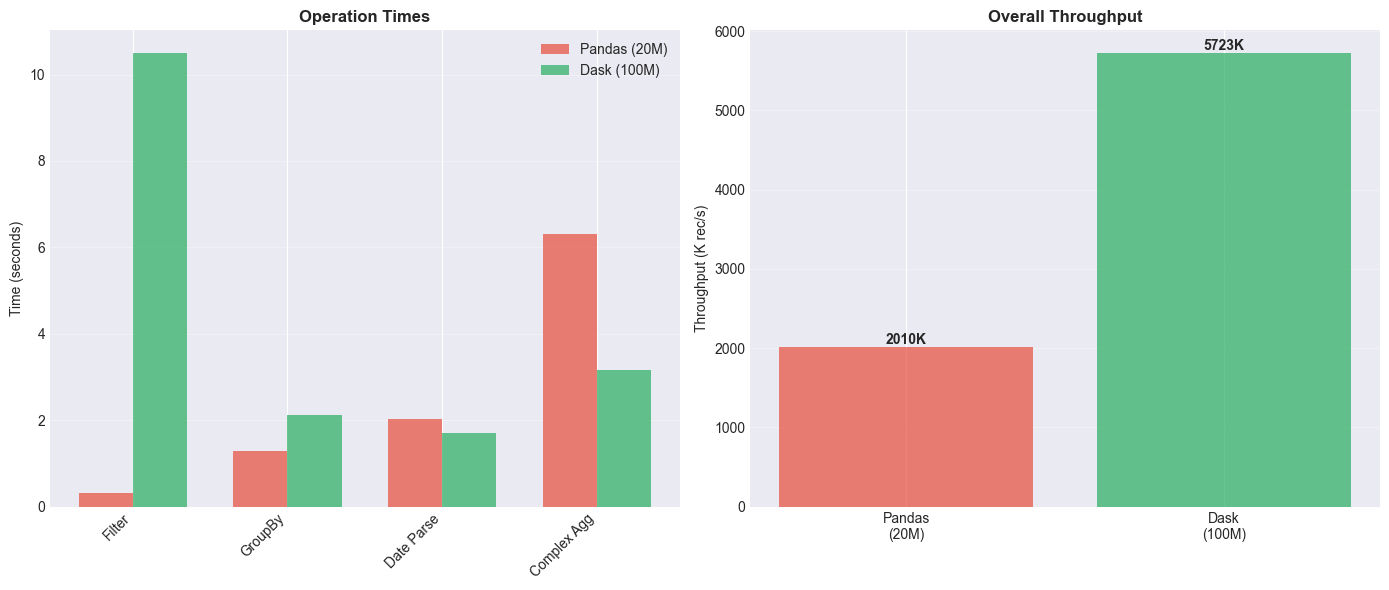


Saved: 02_pandas_vs_dask.png


In [16]:
# PANDAS VS DASK COMPARISON

print("="*70)
print("PANDAS VS DASK COMPARISON")
print("="*70 + "\n")

# From Notebook 1
pandas_results_csv = pd.read_csv(RESULTS_DIR / '01_baseline_performance.csv')

pandas_results = {
    'Dataset': '20M',
    'Filter': pandas_results_csv.iloc[0,1],
    'GroupBy': pandas_results_csv.iloc[1,1],
    'Date Parse': pandas_results_csv.iloc[2,1],
    'Complex Agg': pandas_results_csv.iloc[3,1],

}
pandas_results['Total'] = (
    pandas_results['Filter'] + 
    pandas_results['GroupBy'] + 
    pandas_results['Date Parse'] + 
    pandas_results['Complex Agg'])


dask_results = {
    'Dataset': '100M',
    'Filter': dask_performance['Filter'],
    'GroupBy': dask_performance['GroupBy'],
    'Date Parse': dask_performance['Date Parse'],
    'Complex Agg': dask_performance['Complex Agg'],
    'Total': sum(dask_performance.values())
}

comparison = pd.DataFrame({
    'Pandas (20M)': pandas_results,
    'Dask (100M)': dask_results
})

print(comparison)

comparison.to_csv(RESULTS_DIR / '02_pandas_vs_dask.csv')

#Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Time comparison
ax1 = axes[0]
ops = ['Filter', 'GroupBy', 'Date Parse', 'Complex Agg']
pandas_t = [pandas_results[op] for op in ops]
dask_t = [dask_results[op] for op in ops]

x = np.arange(len(ops))
width = 0.35

ax1.bar(x - width/2, pandas_t, width, label='Pandas (20M)', color='#e74c3c', alpha=0.7)
ax1.bar(x + width/2, dask_t, width, label='Dask (100M)', color='#27ae60', alpha=0.7)

ax1.set_ylabel('Time (seconds)')
ax1.set_title('Operation Times', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(ops, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Throughput
ax2 = axes[1]
pandas_tput = 20_000_000 / pandas_results['Total']
dask_tput = 100_000_000 / dask_results['Total']

bars = ax2.bar(
    ['Pandas\n(20M)', 'Dask\n(100M)'], 
    [pandas_tput/1000, dask_tput/1000],
    color=['#e74c3c', '#27ae60'], alpha=0.7)

ax2.set_ylabel('Throughput (K rec/s)')
ax2.set_title('Overall Throughput', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    h = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2., h,
        f'{h:.0f}K', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '02_pandas_vs_dask.png', dpi=300)
plt.show()

print("\nSaved: 02_pandas_vs_dask.png")

### Analisi Comparativa

**Tempi di Esecuzione**:
Alcune operazioni risultano effettivamente più veloci con Dask rispetto a Pandas. Inoltre, va sottolineato che Pandas fallirebbe completamente o impiegherebbe tempi estremamente lunghi quando si lavora con dataset da 100 milioni di record.

**Throughput**:
Dal punto di vista della velocità di elaborazione, Dask raggiunge circa 5.7M di records al secondo, mentre Pandas si ferma intorno ai 2M di records al secondo. Questo si traduce in un miglioramento di almeno 2.85x nella velocità complessiva di processamento.

**Memory Efficiency**:
Pandas presenta un'espansione della memoria di circa 4.4x rispetto alla dimensione del file originale quando i dati vengono caricati in RAM. Dask, al contrario, mantiene un utilizzo costante della memoria grazie alla sua capacità di elaborazione out-of-core, ovvero senza dover caricare l'intero dataset in memoria.


Il vantaggio di Dask si basa su quattro pilastri fondamentali.

**1. Parallel Processing**
Il calcolo distribuito consente di utilizzare tutti i core della CPU simultaneamente, mentre Pandas rimane limitato a un singolo thread di esecuzione.

**2. Out-of-Core Computing**
La capacità di computing out-of-core permette a Dask di elaborare i dati in blocchi successivi, superando così i vincoli imposti dalla dimensione della RAM disponibile.

**3. Lazy Evaluation**
La lazy evaluation ottimizza l'intero flusso di lavoro prima dell'esecuzione, eliminando le operazioni ridondanti e massimizzando l'efficienza.

**4. Efficient Partitioning**
Il partizionamento efficiente garantisce dimensioni ottimali dei blocchi di dati, minimizzando l'overhead di gestione e massimizzando le prestazioni complessive del sistema.


# Analisi della Scalabilità

L'esperimento prevede l'elaborazione di sottoinsiemi di dati di dimensioni crescenti, partendo da 10 milioni di record e aumentando progressivamente fino a raggiungere i 100 milioni di record.

**Parametri di Misurazione**

L'analisi si concentra su tre aspetti fondamentali: il tempo di esecuzione per ciascuna dimensione del dataset, il throughput espresso in record elaborati al secondo, e il pattern di scalabilità, che può essere lineare, sub-lineare o super-lineare.

**Risultato Atteso**

Ci si aspetta una scalabilità quasi lineare, dove raddoppiando la quantità di dati il tempo di elaborazione dovrebbe approssimativamente raddoppiare. Il throughput dovrebbe mantenersi relativamente costante e non si dovrebbe osservare alcun degrado delle prestazioni all'aumentare del volume di dati.

Questa analisi vuole dimostrare la capacità di Dask di gestire dataset ancora più grandi, anche nell'ordine del miliardo di record o oltre, semplicemente aumentando il tempo di elaborazione in modo proporzionale. A differenza di Pandas, che incontra limiti invalicabili legati alla memoria disponibile, Dask non si scontra con barriere tecnologiche che ne impediscono l'applicazione a dataset di dimensioni arbitrarie.

PART 8: SCALABILITY ANALYSIS

Cluster started
  Dashboard: http://127.0.0.1:37939/status

Testing ~10M records...
    Rows: 10000000
    9.88s, 1012K rec/s

Testing ~20M records...
    Rows: 20000002
    10.62s, 1883K rec/s

Testing ~30M records...
    Rows: 30000000
    11.57s, 2593K rec/s

Testing ~40M records...
    Rows: 40000001
    12.27s, 3260K rec/s

Testing ~50M records...
    Rows: 49999997
    13.10s, 3816K rec/s

Testing ~60M records...
    Rows: 59999999
    13.91s, 4313K rec/s

Testing ~70M records...
    Rows: 70000004
    15.29s, 4578K rec/s

Testing ~80M records...
    Rows: 79999998
    15.77s, 5074K rec/s

Testing ~90M records...
    Rows: 89999996
    17.27s, 5213K rec/s

Testing ~100M records...
    Rows: 100000000
    17.56s, 5695K rec/s

Test results:
 Size (M)  Time (s)  Throughput (K/s)
    10.00      9.88           1012.34
    20.00     10.62           1883.02
    30.00     11.57           2592.92
    40.00     12.27           3260.47
    50.00     13.10      

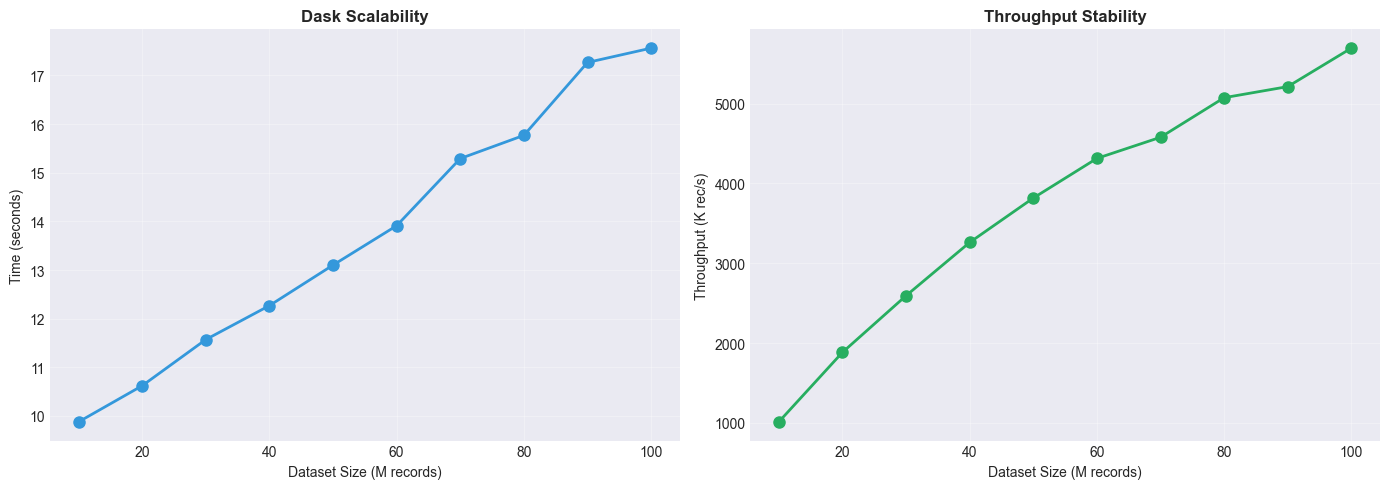

Saved: 02_scalability.png

Closing Dask client...
Client closed


In [21]:
# SCALABILITY ANALISYS

print("="*70)
print("PART 8: SCALABILITY ANALYSIS")
print("="*70 + "\n")

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
scale_results = []

cluster = LocalCluster(
    n_workers=6,
    threads_per_worker=2,
    memory_limit='2GB',
    dashboard_address=':8787',
    silence_logs='ERROR',
    processes=True
)
client = Client(cluster)

print(f"Cluster started")
print(f"  Dashboard: {client.dashboard_link}")

df = dd.read_parquet(
    TRANSACTIONS_FILE, 
    dtype=dtypes,
)

for frac in test_sizes:
    print(f"\nTesting ~{frac * 100:.0f}M records...")
    
    
    # Create subset
    df_subset = df.sample(frac=frac).repartition(npartitions=48)
    nrows = len(df_subset)
    print(f"    Rows: {nrows}")
    
    # Test
    start = time.time()
    result = df_subset.groupby('payment_method')['final_amount'].sum().compute()
    elapsed = time.time() - start
    
    tput = (nrows / elapsed) / 1000
    
    scale_results.append({
        'Size (M)': nrows/1_000_000,
        'Time (s)': elapsed,
        'Throughput (K/s)': tput
    })
    
    print(f"    {elapsed:.2f}s, {tput:.0f}K rec/s")

    del df_subset, result
    gc.collect()
    time.sleep(5)

scale_df = pd.DataFrame(scale_results)
print("\nTest results:")
print(scale_df.round(2).to_string(index=False))

scale_df.to_csv(RESULTS_DIR / '02_scalability.csv', index=False)
print("\nSaved: 02_scalability.csv")

# Visualization 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time vs Size
ax1 = axes[0]
ax1.plot(
    scale_df['Size (M)'], scale_df['Time (s)'], 
    marker='o', linewidth=2, markersize=8, color='#3498db')
ax1.set_xlabel('Dataset Size (M records)')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Dask Scalability', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Throughput
ax2 = axes[1]
ax2.plot(
    scale_df['Size (M)'], scale_df['Throughput (K/s)'], 
    marker='o', linewidth=2, markersize=8, color='#27ae60')
ax2.set_xlabel('Dataset Size (M records)')
ax2.set_ylabel('Throughput (K rec/s)')
ax2.set_title('Throughput Stability', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '02_scalability.png', dpi=300)
plt.show()

print("Saved: 02_scalability.png")

# Cleanup
print("\nClosing Dask client...")
client.close()
cluster.close()
print("Client closed")

## Analisi della Scalabilità - Osservazioni

**Pattern di Scalabilità**

I risultati mostrano che il tempo di esecuzione aumenta approssimativamente in modo lineare rispetto alla dimensione dei dati. Il throughput mostra un andamento crescente che tende ad assestarsi al crescere del volume di dati e non si osserva alcun improvviso degrado delle prestazioni all'aumentare del volume di dati elaborati.

**Il Limite di Scalabilità**

Anche Dask ha i suoi limiti quando utilizzato su una singola macchina, che si attestano intorno al miliardo di record. Per elaborare volumi superiori, diventa necessario passare a PySpark con un cluster multi-macchina, che consente di distribuire il carico computazionale su più nodi fisici.

# Conclusioni

L'esperienza con Dask ha dimostrato risultati significativi su diversi fronti. È stato possibile elaborare in modo efficiente 100 milioni di record, gestendo un volume di dati cinque volte superiore rispetto a quanto Pandas permetterebbe di fare in tempi comparabili.
Il computing out-of-core si è rivelato una soluzione perfettamente funzionante, operando in modo trasparente senza richiedere interventi manuali complessi.
Infine, la dashboard di monitoraggio si è dimostrata uno strumento fondamentale per l'utilizzo in ambienti di produzione, permettendo di tenere sotto controllo le prestazioni del sistema e identificare tempestivamente eventuali problematiche durante l'elaborazione.